In [1]:
# Import libraries and functions
import random
import math
import torch
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
# General Setup
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pd.set_option('display.max_rows', 500)
print(device)

cuda


In [2]:
# load and modify the training data
df = pd.read_csv('C:\\Users\\Kkda\\Desktop\\Stat 441 Final Project\\Pokemon_train.csv')
df = df.drop(columns=["has_gender","sprite_perimeter","sprite_size","sprite_overflow_vertical","sprite_overflow_horizontal","height_m"])

# Define column names
categorical = ['type_2','status']

numerical = ['generation', 'type_number', 'weight_kg', 'abilities_number','total_points', 'hp', 'attack',
             'defense', 'sp_attack', 'sp_defense', 'speed', 'catch_rate', 'base_friendship', 'base_experience',
             'maximum_experience', 'egg_type_number', 'proportion_male', 'egg_cycles', 'sprite_perimeter_to_size_ratio',
             'sprite_red_mean', 'sprite_green_mean', 'sprite_blue_mean','sprite_brightness_mean', 'sprite_red_sd', 
             'sprite_green_sd', 'sprite_blue_sd', 'sprite_brightness_sd',]

weakness = ['damage_from_normal', 'damage_from_fire', 'damage_from_water', 'damage_from_electric',
            'damage_from_grass', 'damage_from_ice', 'damage_from_fighting', 'damage_from_poison',
            'damage_from_ground', 'damage_from_flying', 'damage_from_psychic', 'damage_from_bug','damage_from_rock',
            'damage_from_ghost', 'damage_from_dragon', 'damage_from_dark','damage_from_steel', 'damage_from_fairy']

# Define class and features
y = df['type_1']
X = df.drop(['type_1'],axis=1)

# Encode categorical variables
y_encoded = pd.get_dummies(y)
X_encoded = pd.get_dummies(X,columns=categorical)

# Scale numerical variables
scaler = MinMaxScaler()
num_numeric = sum(X_encoded.dtypes == ["float64"]*X_encoded.shape[1])
X_encoded.iloc[:,:num_numeric] = scaler.fit_transform(X_encoded.iloc[:,:num_numeric])

# Convert X_encoded, y_encoded into PyTorch tensor
y_tensor = torch.tensor(y_encoded.values).float()
X_tensor = torch.tensor(X_encoded.values).float()

# Set up number classes and features
n_class = 18
n_feature = X_tensor.shape[1]

In [13]:
# load and modify the testing data
df_test = pd.read_csv('C:\\Users\\Kkda\\Desktop\\Stat 441 Final Project\\Pokemon_test.csv')
df_test = df_test.drop(columns=["has_gender","sprite_perimeter","sprite_size","sprite_overflow_vertical","sprite_overflow_horizontal","height_m"])

# Define class and features
y_test = df_test['type_1']
X_test = df_test.drop(['type_1'],axis=1)

# Encode categorical variables
y_encoded_test = pd.get_dummies(y_test)
X_encoded_test = pd.get_dummies(X_test,columns=categorical)

# Scale numerical variables
scaler = MinMaxScaler()
num_numeric = sum(X_encoded_test.dtypes == ["float64"]*X_encoded_test.shape[1])
X_encoded_test.iloc[:,:num_numeric] = scaler.fit_transform(X_encoded_test.iloc[:,:num_numeric])

# Convert X_encoded, y_encoded into PyTorch tensor
y_tensor_test = torch.tensor(y_encoded_test.values).float()
X_tensor_test = torch.tensor(X_encoded_test.values).float()

In [3]:
# Define model
class NN(nn.Module):
    def __init__(self, node_list):
        super(NN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(1, len(node_list)):
            self.layers.append(nn.Linear(node_list[i-1], node_list[i]))
        self.activation = nn.ReLU()

    def forward(self, x):
        out = x
        for i in range(len(self.layers)-1):
            out = self.layers[i](out)
            out = self.activation(out)
        out = self.layers[len(self.layers)-1](out)
#         m = nn.Softmax(dim=1)
#         out = m(out)
        return out

In [4]:
# Prediction function
def predict(model, X, y):
    
    # Set up loader and initialize
    test_dataset = TensorDataset(X,y)
    loader = DataLoader(test_dataset, batch_size = 9999, shuffle = False)
    num_correct = 0
    num_samples = 0
    
    # Set to model evaluation
    model.eval()
    
    # Evaluate model
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0], -1)
            model_result = model(x)
            _, prediction = model_result.max(1)
            _, actual = y.max(1)
            num_correct += (prediction == actual).sum()
            num_samples += prediction.size(0)
    
    # Set to model training
    model.train()
    
    return prediction.cpu().numpy(), actual.cpu().numpy(), num_correct/num_samples

In [5]:
# Training function
# Input: Model hyper parameters, training and testing data
# Output: Model, Loss
def train_model(learning_rate, num_epochs, batch_size, node_list, X, y):

    # Create the model
    model = NN([n_feature]+node_list+[n_class]).to(device)

    # Set up loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Set up data loader
    train_dataset = TensorDataset(X,y)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    
    # Initialize loss
    loss = []
    
    # Train model
    for epoch in range(num_epochs):
        for batch_idx, (data, targets) in enumerate(train_loader):
            # Get data to cuda if possible
            data = data.to(device = device)
            targets = targets.to(device = device)

            # Reshape data
            data = data.reshape(data.shape[0], -1)
            
            # Forward propagation
            model_result = model(data)
            current_loss = criterion(model_result, targets)
            
            # Zero previous gradients
            optimizer.zero_grad()
            
            # back-propagation
            current_loss.backward()
            
            # optimize
            optimizer.step()
        
        # Record loss for current epoch
        loss.append(float(current_loss.item()))
        
    return model, loss

NN(
  (layers): ModuleList(
    (0): Linear(in_features=68, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): Linear(in_features=64, out_features=18, bias=True)
  )
  (activation): ReLU()
)
tensor(0.9464, device='cuda:0')
[ 5 14  9  8 15 12  6 14  9 15 17  1  9 15  1  9 16  1  3  9 17  0 12 13
 14 13 13 17 17 17 13 16  2  2  1 12 17 10  0 16 11  9  4 12 17 14  9  1
 17  1  0 17 11 14  9 15  3  1  5 11  1 11 17 17  9  5  6  0 16 15 13 12
 16  5 17 14  9  2  0 14 14  6 14  9  8 14 15  9 17  0 17 14 14 10  3 12
 12  4  9  5 11 12 14  1 13  1  6  9  0 12  0  1  0  9  6  0  0 15 10  1
  5 17  8  0 14 17  0  9 14 12 12 14 14  0  8 14 14  6 17 14 14 12  2 17
  1  9  3  1 12 16 16 14 17  9  3  6  9 16 10  3 16 12  6 13  4 14 12 16]
[ 5 14  9  8 15 12  6 14  9 15 17  1  9 15  1  9 16  1  3  9 17  0 12 13
 14  7 13 17 17 17 13 

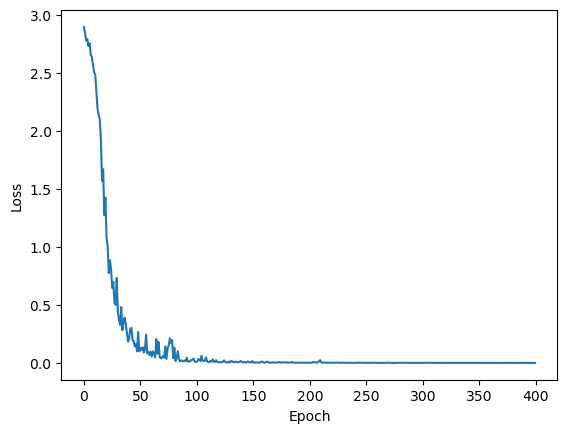

In [6]:
# Check training function and prediction function

# Prepare data
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=random.seed(time.time()))

# Model parameters
learning_rate,num_epochs,batch_size = 0.001,400,100
node_list = [64,128,128,64]

model, loss = train_model(learning_rate, num_epochs, batch_size, node_list, X_train, y_train)
prediction, actual, accuracy = predict(model, X_test, y_test)

# Print model result
print(model)
print(accuracy)
print(prediction)
print(actual)
print(prediction==actual)

# Plot loss
plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Examine the performence of NN

In [7]:
# Initialize
n_model = 1500;
b_lrs = [0]*n_model
b_n_epochs = [0]*n_model
b_n_layers = [0]*n_model
b_batch_size = [0]*n_model
b_node_list = [[]]*n_model
b_accuracy = [0]*n_model

In [8]:
# Try Optimize the model parameters
# We do so by randomly generating 10000 models and record the best models found

generate = 1500
for ii in tqdm(range(generate)):
    # Set up model hyper parameters
    learning_rate = round(random.uniform(0.001,0.01),4)
    num_epochs = random.randint(50,250) # generate num of epoches
    batch_size = random.randint(50,250) # generate batch size
    num_hidden_layer = random.randint(2,6) # generate number of hidden layers
    
    # Generate node_list
    a = random.randint(64,192)
    b = random.randint(a,math.floor(1.5*a))
    c = random.randint(b,math.floor(1.5*b))
    node_lists = [[a,a],[a,b,a],[a,b,b,a],[a,b,c,b,a],[a,b,c,c,b,a]]
    node_list = node_lists[num_hidden_layer-2]
    
    # Examine the average model performance
    fit = 10
    accuracy = 0
    for jj in range(fit):
        # Prepare data
        X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size = 0.2, random_state = random.seed(time.time()))
        
        # Train model using the given hyper parameters and data
        model, _ = train_model(learning_rate, num_epochs, batch_size, node_list, X_train, y_train)
        
        # Calculate accuracy of the model on test data
        _,_, acc_temp = predict(model, X_test, y_test)
        
        # Add up accuracy
        accuracy = accuracy + acc_temp
    
    # Compute average accuracy
    accuracy = accuracy/fit
    accuracy = accuracy.item()
    # Update model if the model trained using current hyper parameters perform better
    min_accuracy = min(b_accuracy)v  nm
    if accuracy > min_accuracy:
        index = b_accuracy.index(min_accuracy)
        b_lrs[index] = learning_rate
        b_n_epochs[index] = num_epochs
        b_n_layers[index] = num_hidden_layer
        b_batch_size[index] = batch_size
        b_node_list[index] = node_list
        b_accuracy[index] = accuracy

  0%|          | 0/1500 [00:00<?, ?it/s]

In [9]:
max(b_accuracy)

0.987500011920929

In [14]:
# Compute actual accuracy

actual_accuracy = [0]*n_model
for ii in tqdm(range(n_model)):
    # Set up model hyper parameters
    learning_rate = b_lrs[ii]
    num_epochs = b_n_epochs[ii]
    batch_size = b_batch_size[ii]
    node_list = b_node_list[ii]
    num_hidden_layer = len(node_list)
    
    model, _ = train_model(learning_rate, num_epochs, batch_size, node_list, X_tensor, y_tensor)
    _,_, acc_temp = predict(model, X_tensor_test, y_tensor_test)
    
    actual_accuracy[ii] = acc_temp.item()

  0%|          | 0/1500 [00:00<?, ?it/s]

In [15]:
asd = actual_accuracy.index(max(actual_accuracy))
print(b_node_list[asd])
print(b_n_epochs[asd])
print(b_n_layers[asd])
print(b_batch_size[asd])
print(b_accuracy[asd])
print(actual_accuracy[asd])

[157, 157]
199
2
207
0.9839286208152771
0.9952152967453003
